# Movie Profit Prediction Using Text

This notebook works through classification and clustering models related to predicting the profit of movies released between 1995 and June 2018 using text analysis.  The related GitHub for this project is here: https://github.com/georgetown-analytics/Box-Office.  

The raw data sources were cleaned, wrangled, and pre-processed in separate python codes stored here: https://github.com/georgetown-analytics/Box-Office/tree/master/codes.  These notebooks are for the modeling stage of the project.

In [152]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, 
    LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV)
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.neural_network import MLPClassifier

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from yellowbrick.classifier import ClassificationReport, ROCAUC
from yellowbrick.features import FeatureImportances

from imblearn.over_sampling import SMOTE

from sklearn.tree import export_graphviz
import pydot

%matplotlib inline

In [153]:
import warnings
warnings.filterwarnings('ignore')

In [154]:
con = sql.connect(r'c:\users\rebecca\projs\Box-Office\database\movies.db') 

data = pd_sql.read_sql('select * from finalMovies_20180814', con, index_col='index')

# Classification Models

We can try to develop classes of movies in order to use classification models.  So, this section will look at whether we can predict movie profitability.  We will use a feature we created during the pre-processing step: "Profit_Bucket", which indicates whether a movie made less than its budget, same as its budget, twice its budget, three times, etc.  The classes are: <1x, [1-2x), [2-3x), [3-4x), [4-5x), and >=5x.  

From this, we will create an additional feature called "Profit_Bucket_Binary" which will equal a 1 if the movie made at least twice its budget, and 0 if not.  We chose this threshold because in some of the literature regarding movie profitability, a rule-of-thumb some people follow is a movie likely makes a profit if it makes at least twice its production budget.  This is due to the extra costs of marketing, distribution, and other expenses.

Some of the codes to run models were taken from some labs we did in Dr. Bari's class and Dr. Bengfort's class.

### Create Profit Bucket Binary variable and set (X, y) train and test sets

We will create the new feature "Profit_Bucket_Binary" and set the train and test sets that we will use for all the classification model testing. 

In [155]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $100,000, if 
#we choose to.
movies = data[(data['Revenue_Real']>0)&(data['Budget_Real']>0)&(data['Length']>0)]

#Make binary variable for if movie made at least 2x budget
movies['Profit_Bucket_Binary']=np.where(movies['Profit_Bucket']=='<1x', 0, np.where(movies['Profit_Bucket']=='[1-2x)', 
                        0, np.where(movies['Profit_Bucket']=='[2-3x)', 1, np.where(movies['Profit_Bucket']=='[3-4x)', 
                        1, np.where(movies['Profit_Bucket']=='[4-5x)', 1, np.where(movies['Profit_Bucket']=='>=5x', 1, ''))))))


0    2539
1    1875
Name: Profit_Bucket_Binary, dtype: int64


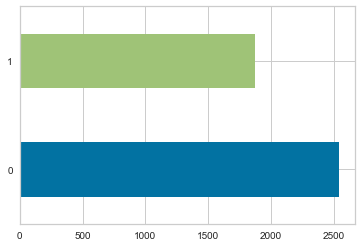

In [156]:
#Show distribution of profit bucket binary
%matplotlib inline
print(movies['Profit_Bucket_Binary'].value_counts())
movies['Profit_Bucket_Binary'].value_counts().plot(kind='barh')
plt.show()

In [157]:
classifiers = [
    #LogisticRegressionCV(random_state=1, cv=5),
    #LogisticRegression(random_state=1),
    #RandomForestClassifier(n_estimators=50, oob_score=True),
    #XGBClassifier(), #Don't know why, but this model isn't working when using SMOTE.  
    #BaggingClassifier(), 
    #ExtraTreesClassifier(),
    #AdaBoostClassifier(),
    #GradientBoostingClassifier(),
    #MultinomialNB(),
    #SGDClassifier(),
    ##GaussianNB(),
    #MLPClassifier(),
    ##SVC(kernel='linear'),
    #SVC(kernel='rbf'),
    ##SVC(kernel='poly', degree=3),
    #KNeighborsClassifier(), 
    LinearSVC()]

### Part 1. Use Movie Tagline

We will first try using the movie tagline to see if we can predict a movie's profitability class. The Tagline feature is the shortest text feature we have in our dataset.

Some portions of this code were adapted from sklearn's documentation on text analysis: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [158]:
tagline = movies[pd.notnull(movies['Tagline'])]

#Set X, y
X = tagline[["Tagline"]]
y = tagline["Profit_Bucket_Binary"]

# Next split up the data with the 'train test split' method in the Cross Validation module
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

0    2121
1    1736
Name: Profit_Bucket_Binary, dtype: int64


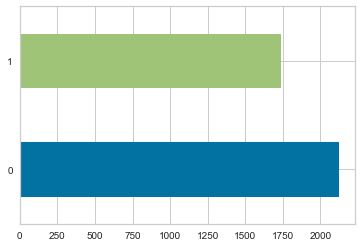

In [159]:
#Show distribution of profit bucket binary after restricting not null Tagline column
%matplotlib inline
print(tagline['Profit_Bucket_Binary'].value_counts())
tagline['Profit_Bucket_Binary'].value_counts().plot(kind='barh')
plt.show()

In [160]:
#X['Tagline'][0]
#X_train.shape, y_train.shape
#print(X_train)

In [161]:
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
X_train_counts = count_vect.transform(X_train.Tagline)
X_train_counts.shape


#print(X_train_counts)
#vectorizer.fit(X_train.Tagline)
## summarize
#print(vectorizer.vocabulary_)

X_test_counts = count_vect.transform(X_test.Tagline)
X_test_counts.shape


(772, 3660)

In [162]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_test_tfidf.shape

(772, 3660)

LinearSVC [0.59661017 0.45827011]


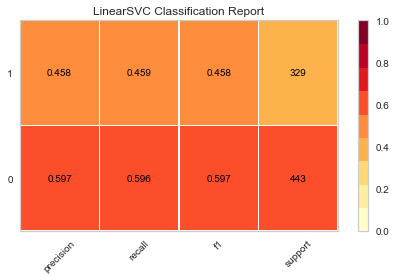

In [163]:
for clf in classifiers:
    clf.fit(X_train_tfidf, y_train)
    name = clf.__class__.__name__
    expected = y_test
    predicted = clf.predict(X_test_tfidf)
    print(name, (f1_score(expected, predicted, average=None)))
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train_tfidf, y_train)
    oz.score(X_test_tfidf, y_test)
    oz.poof()

In [164]:
#plot.coefficients(clf, vectorizer.get_feature_names())

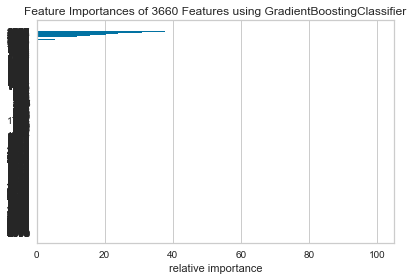

In [165]:
oz=FeatureImportances(GradientBoostingClassifier())
oz.fit(X_train_tfidf, y_train)
oz.poof()

### Part 2. Use Movie Plot

We will next try using the movie plot to see if we can predict a movie's profitability class. The Plot feature is the next longest text feature we have in our dataset.

Some portions of this code were adapted from sklearn's documentation on text analysis: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [166]:
plot = movies[pd.notnull(movies['Plot'])]

#Set X, y
X = plot[["Plot"]]
y = plot["Profit_Bucket_Binary"]

# Next split up the data with the 'train test split' method in the Cross Validation module
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

0    2539
1    1875
Name: Profit_Bucket_Binary, dtype: int64


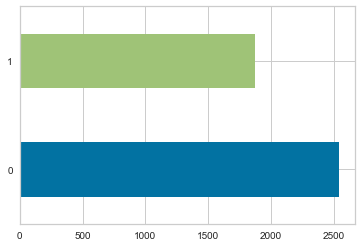

In [167]:
#Show distribution of profit bucket binary after restricting not null Tagline column
%matplotlib inline
print(plot['Profit_Bucket_Binary'].value_counts())
plot['Profit_Bucket_Binary'].value_counts().plot(kind='barh')
plt.show()

In [168]:
#X['Tagline'][0]
#X_train.shape, y_train.shape
#print(X_train)

In [169]:
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
X_train_counts = count_vect.transform(X_train.Plot)
X_train_counts.shape


#print(X_train_counts)
#vectorizer.fit(X_train.Tagline)
## summarize
#print(vectorizer.vocabulary_)

X_test_counts = count_vect.transform(X_test.Plot)
X_test_counts.shape


(883, 3660)

In [170]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_test_tfidf.shape

(883, 3660)

LinearSVC [0.64326376 0.47191011]


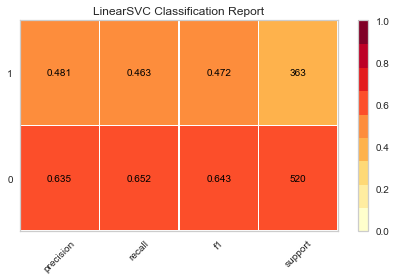

In [171]:
for clf in classifiers:
    clf.fit(X_train_tfidf, y_train)
    name = clf.__class__.__name__
    expected = y_test
    predicted = clf.predict(X_test_tfidf)
    print(name, (f1_score(expected, predicted, average=None)))
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train_tfidf, y_train)
    oz.score(X_test_tfidf, y_test)
    oz.poof()

### Part 3. Use Movie Overview

We will next try using the movie overview to see if we can predict a movie's profitability class. The Overview feature is the longest text feature we have in our dataset.

Some portions of this code were adapted from sklearn's documentation on text analysis: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [172]:
overview = movies[pd.notnull(movies['Overview'])]

#Set X, y
X = overview[["Overview"]]
y = overview["Profit_Bucket_Binary"]

# Next split up the data with the 'train test split' method in the Cross Validation module
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

0    2539
1    1875
Name: Profit_Bucket_Binary, dtype: int64


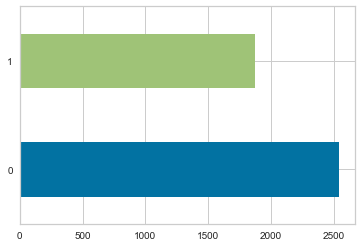

In [173]:
#Show distribution of profit bucket binary after restricting not null Tagline column
%matplotlib inline
print(overview['Profit_Bucket_Binary'].value_counts())
overview['Profit_Bucket_Binary'].value_counts().plot(kind='barh')
plt.show()

In [174]:
#X['Tagline'][0]
#X_train.shape, y_train.shape
#print(X_train)

In [175]:
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
X_train_counts = count_vect.transform(X_train.Overview)
X_train_counts.shape


#print(X_train_counts)
#vectorizer.fit(X_train.Tagline)
## summarize
#print(vectorizer.vocabulary_)

X_test_counts = count_vect.transform(X_test.Overview)
X_test_counts.shape


(883, 3660)

In [176]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_test_tfidf.shape

(883, 3660)

LinearSVC [0.62748815 0.44725738]


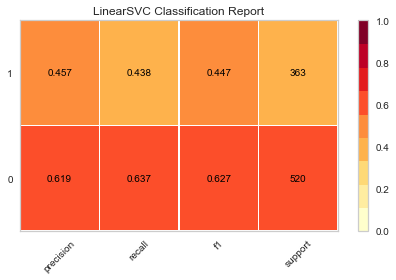

In [177]:
for clf in classifiers:
    clf.fit(X_train_tfidf, y_train)
    name = clf.__class__.__name__
    expected = y_test
    predicted = clf.predict(X_test_tfidf)
    print(name, (f1_score(expected, predicted, average=None)))
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train_tfidf, y_train)
    oz.score(X_test_tfidf, y_test)
    oz.poof()